# Importando Bibliotecas

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame as df
from scipy.stats import zscore
import seaborn as sns
import re
import os

from ydata_profiling import ProfileReport
import sweetviz as sv

# Carregando e inspecionando dados

In [36]:
data = pd.read_csv("./data/card_transdata.csv", na_values=[' ', '_', '_______'], low_memory=False)

In [37]:
# Mostra as primeiras 5 linhas
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [38]:
# Obtendo informações sobre cada variável
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [39]:
# número de colunas
print(f'columns: {data.shape[1]}')

# número de linhas
print(f'rows: {data.shape[0]}')

columns: 8
rows: 1000000


# Limpeza de dados

## 1. Valores ausentes

In [40]:
# Verifique a soma dos valores ausentes para cada coluna
data.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

## 2. Valores duplicados

In [41]:
# Verifique a soma das linhas duplicadas
print(f'duplicate rows: {data.duplicated().sum()}')

duplicate rows: 0


O conjunto de dados NÃO tem linhas duplicadas

# Algumas informações estatísticas

In [42]:
# Criando uma tabela de estatísticas descritivas para dados
data.describe().T

,count,mean,std,min,25%,50%,75%,max
distance_from_home,1000000.0,26.628792,65.390784,0.004874,3.878008,9.967760,25.743985,10632.723672
distance_from_last_transaction,1000000.0,5.036519,25.843093,0.000118,0.296671,0.998650,3.355748,11851.104565
ratio_to_median_purchase_price,1000000.0,1.824182,2.799589,0.004399,0.475673,0.997717,2.096370,267.802942
repeat_retailer,1000000.0,0.881536,0.323157,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,1000000.0,0.350399,0.477095,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,1000000.0,0.100608,0.300809,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,1000000.0,0.650552,0.476796,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,1000000.0,0.087403,0.282425,0.000000,0.000000,0.000000,0.000000,1.000000


Alguns dos recursos têm valores extremos como "distance_from_home", "distance_from_last_transaction" e "ratio_to_median_purchase_price".

# Correlação de dados

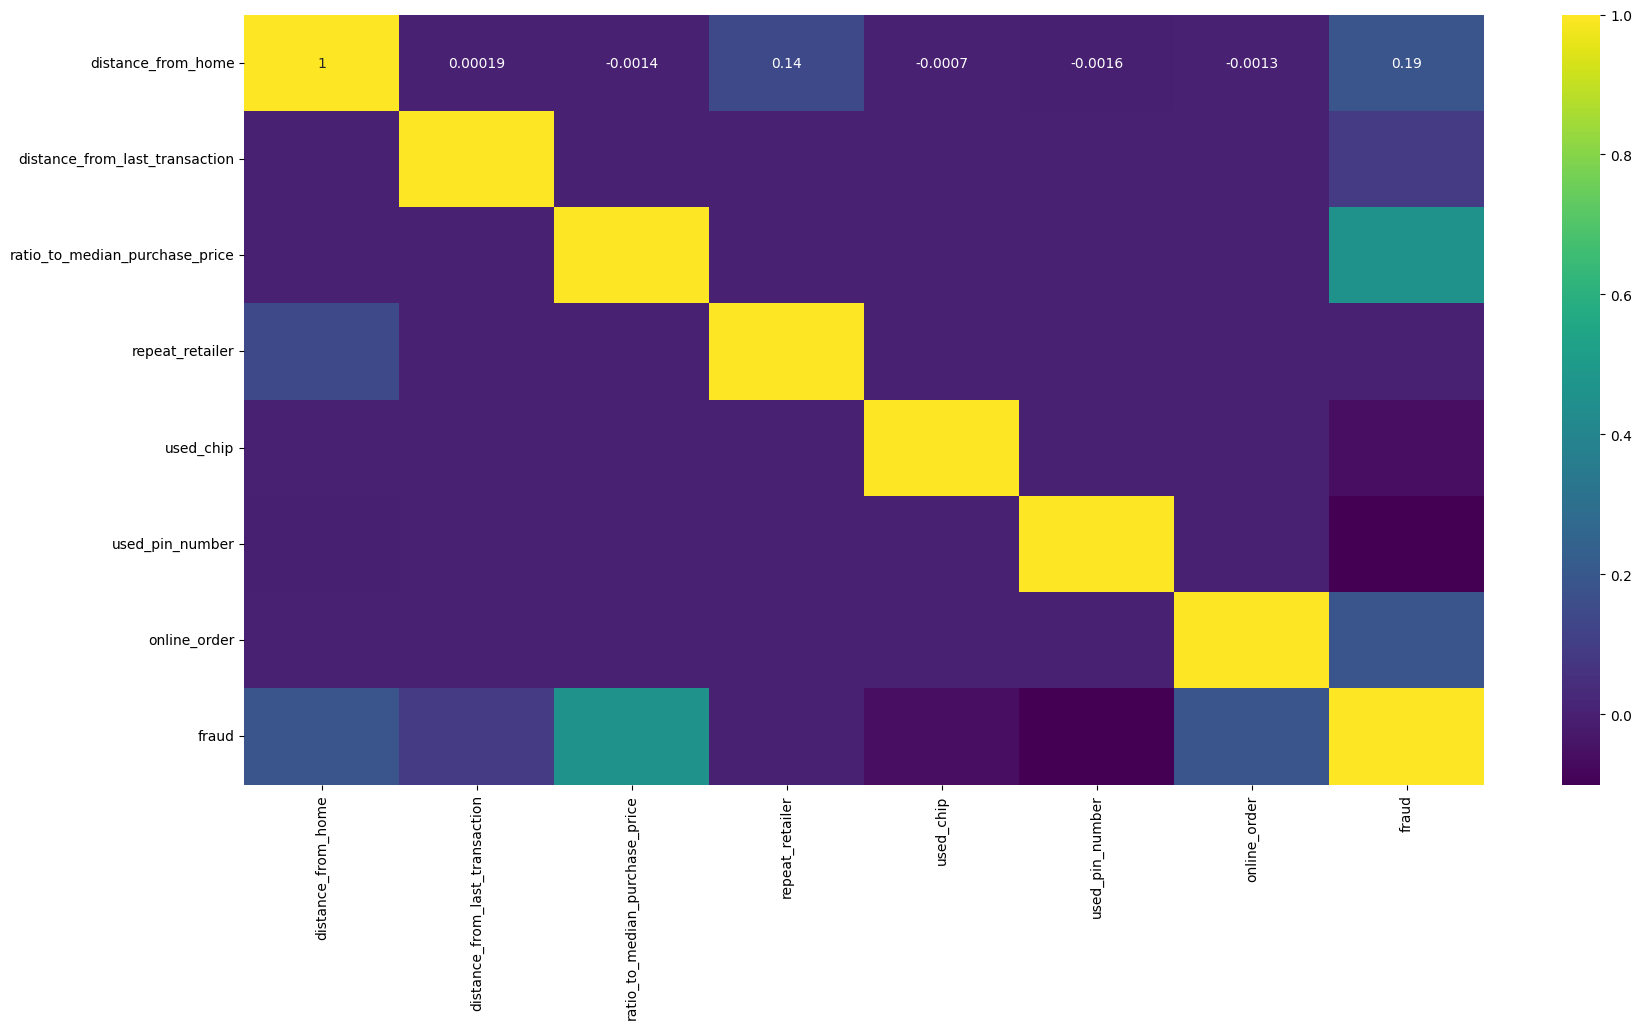

In [43]:
# Mapa de calor para explicar a correlação entre os recursos
plt.figure(figsize = (20, 10))
sns.heatmap(data.corr(), annot = True, cmap='viridis')
plt.show()

In [44]:
# Correlações com fraude
corr = data.corr()['fraud'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

,fraud
fraud,1.000000
ratio_to_median_purchase_price,0.462305
online_order,0.191973
distance_from_home,0.187571
distance_from_last_transaction,0.091917
repeat_retailer,-0.001357
used_chip,-0.060975
used_pin_number,-0.100293


# Análise Exploratória de Dados (EDA)

#### • Análise Univariada

#### • Análise Bi-variada

## 1. Univariate Analysis

### 1.1. Recurso de destino (Fraud)

In [16]:
data['fraud'].value_counts()

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64

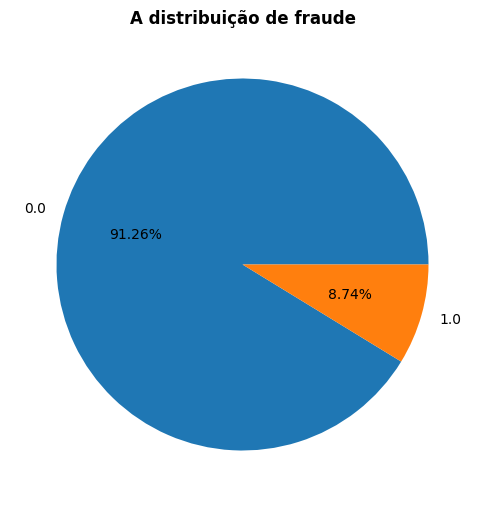

In [45]:
plt.figure(figsize = (6, 8))
plt.pie(x = data['fraud'].value_counts().values,
        labels = data['fraud'].value_counts().index, 
        autopct = '%1.2f%%')
plt.title('A distribuição de fraude', size = 12, weight = 'bold')
plt.show()

##### Observação:

Temos 91,26% de transações genuínas (912.597) e apenas 8,74% (87.403) de transações fraudulentas!

Como os dados na variável fraude estão desequilibrados, é melhor considerar aproveitar as vantagens das técnicas de subamostragem ou sobreamostragem para resolver esse problema.

### 1.2. Recursos Categóricos

In [46]:
# Crie uma lista contendo recursos categóricos
cat_features = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']

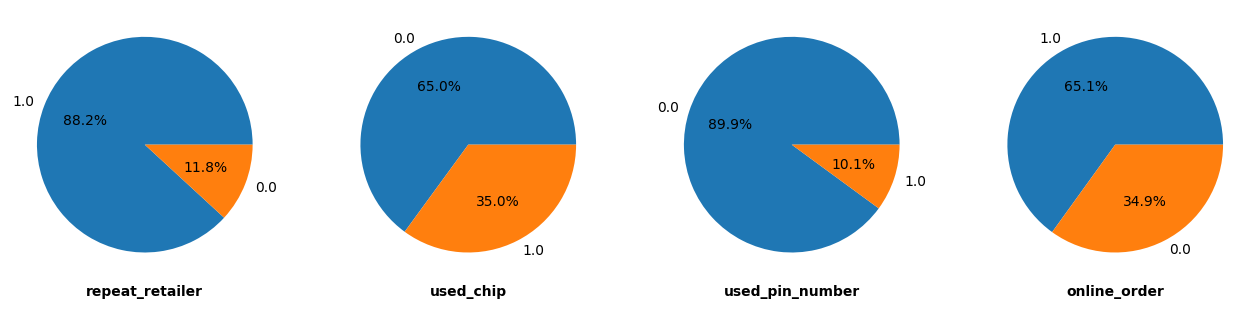

In [47]:
# Desenhar um gráfico de pizza para exibir a distribuição de cada coluna categórica
plt.figure(figsize = (16, 12))
for i, col in enumerate(cat_features):
    plt.subplot(1, 4, i+1)
    plt.pie(x = data[col].value_counts().values, 
            labels = data[col].value_counts().index, 
            autopct = '%1.1f%%')
    plt.xlabel(col, weight = 'bold')
plt.show()

## 2. Análise Bi-variada

### 2.1 Qual é o impacto dos pedidos online e offline na fraude?

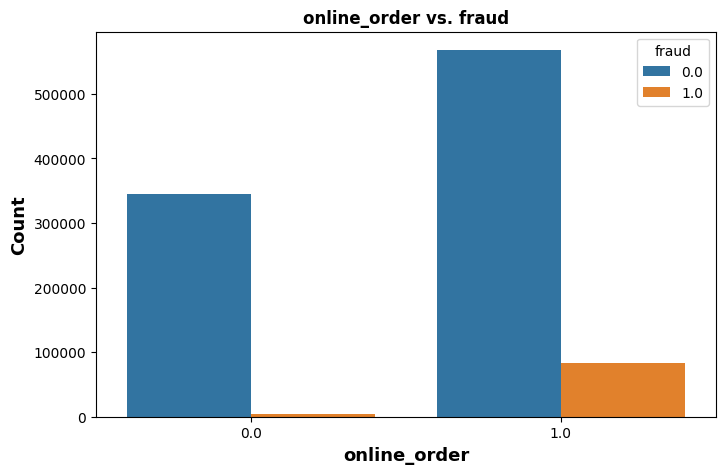

In [48]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'online_order',
              hue = 'fraud')


# Adicione rótulos e título
plt.title('online_order vs. fraud', weight = 'bold')
plt.xlabel('online_order', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

##### Observações:

A fraude é mais comum em casos de pedidos online.

### 2.2. Qual é o impacto do uso do PIN na fraude?

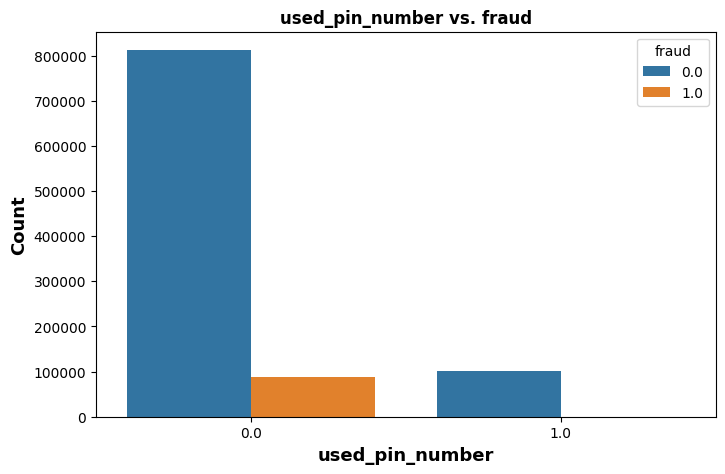

In [49]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'used_pin_number',
              hue = 'fraud')


# Adicione rótulos e título
plt.title('used_pin_number vs. fraud', weight = 'bold')
plt.xlabel('used_pin_number', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

##### Observação:

A fraude é mais comum nos casos em que não se utiliza PIN.

### 2.3. Qual é o impacto do uso de cartões de crédito na fraude?

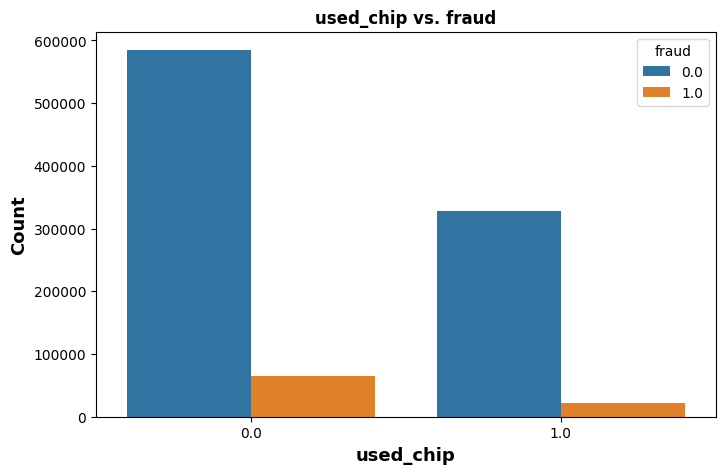

In [50]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'used_chip',
              hue = 'fraud')


# Adicione rótulos e título
plt.title('used_chip vs. fraud', weight = 'bold')
plt.xlabel('used_chip', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

##### Observação:

A fraude é mais comum nos casos em que não se utilizam cartões de crédito.

### 2.4. Qual é o impacto das transações do mesmo varejista na fraude?

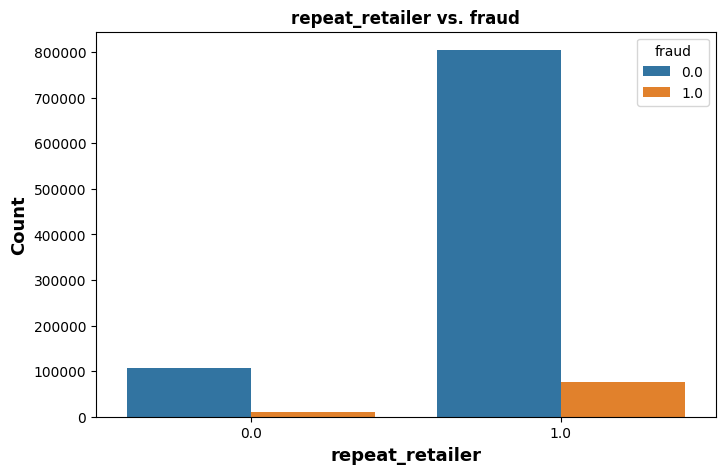

In [51]:
plt.figure(figsize = (8, 5))
sns.countplot(data = data, 
              x = 'repeat_retailer',
              hue = 'fraud')


# Adicione rótulos e título
plt.title('repeat_retailer vs. fraud', weight = 'bold')
plt.xlabel('repeat_retailer', size = 13, weight = 'bold')
plt.ylabel('Count', size = 13, weight = 'bold')
plt.show()

##### Observação:

A fraude é mais comum em casos de transações do mesmo varejista.